In [1]:
using Plots;
gadfly();

In [2]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

In [3]:
#Global parameters
size = 1000;
endTime = 30000;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

# Incident
inc_pos = 200;

# Material
n1 = 4;
n2 = sqrt(n1);

eps1 = n1^2;
eps2 = n2^2;

wavelength = 300;
#Grid

# Magnetic
hy = zeros(size-1);
mu = ones(size-1);

chyh = ones(size);
chye = ones(size);


# Electric
ez = zeros(size);
eps = ones(size) * eps1;

cezh = ones(size);
ceze = ones(size);


#for i in 110:170
#    eps[i] = eps1;
#end
for i in div(size, 2):div(size, 2)+(div(wavelength, 2))
    eps[i] = eps2;
end

rightBound = boundaries.setup_first_order_abc(eps, mu, size, true)
leftBound = boundaries.setup_first_order_abc(eps, mu, 1, false)

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

In [4]:
# Time steps

for time in 1:endTime
    # Incident
    ez_inc = sin(2*pi/(wavelength) * (time-1))*exp(-3000/time);
    hy_inc = sin(2*pi/(wavelength) * (time-1))*exp(-3000/time);
    
    #
    # Magnetic
    #
        
    # Interior update
    update.update_magnetic_field!(ez, hy, mu, chyh, chye);    
    
    # TFSF
    hy[inc_pos-1] -= hy_inc / globals.imp0;
    
    #
    # Electric
    #
       
    # Interior update
    update.update_electric_field!(ez, hy, eps, cezh, ceze);
    
    # ABC
    boundaries.first_order_diff_abc!(ez, leftBound)
    boundaries.first_order_diff_abc!(ez, rightBound)
    
    # TFSF
    ez[inc_pos] += ez_inc / sqrt( eps[inc_pos] * mu[inc_pos])
 
    # Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end

In [5]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    # plot!(1:size-1, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(0.8*size, 1.5, "time =$time")])
    #plot!(ann=[(0, 1.1, "Mur ABC")])
    
    #plot!(ann=[(, 1.3, "Eps = $eps1")])
    #plot!(ann=[(102, 1.1, "Eps =\n= $eps2")])
    #plot!(ann=[(125, 1.3, "Eps = $eps1")])
    plot!([size/2, size/2], [-2, 2])
    plot!([size/2+wavelength/2, size/2+wavelength/2], [-2, 2])
    
    plot!(ann=[(175, 1.1, "Mur ABC")])
    
    plot!(xlims=(1, size), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task3/Half_Wavelength_Reflection_TFSF.gif", fps=15)

[Plots.jl] Initializing backend: gadfly


INFO: Saved animation to /home/pdmitriev/Documents/Github/1d-fdtd/tasks/Task3/Half_Wavelength_Reflection_TFSF.gif


Plots.AnimatedGif("/home/pdmitriev/Documents/Github/1d-fdtd/tasks/Task3/Half_Wavelength_Reflection_TFSF.gif")

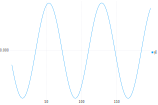

In [6]:
plot(1:size, ez)
plot!(xlims=(1, 195), ylims=(maximum(ez[1:195]),minimum(ez[1:195])))

In [7]:
maximum(ez[1:195])

0.004530087928604855